In [1]:
#Exploration of global prediction on a grid - July 2022
#Compare with Glorys and Armor3D
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw
from gsw import sigma0
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import colorcet as cc

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/epauthen/cartopy_shapefiles'

#Map
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
#extent = np.array([-179, 179, -80, 80])
subplot_kw = {'projection': proj} #, 'extent': extent}

pathfig = '/home1/datawork/epauthen/Fig_Product/Global/'
path_model = "/home/datawork-lops-bluecloud/osnet/models/global3" 
path_out = "/home/datawork-lops-bluecloud/osnet/product_out/global3"

#Create the list of dates
a = pd.date_range(start="1993-01-01",end="2021-12-31")
date_all = pd.Series(a.format())

In [3]:
#Pick a date
i = 0
date = date_all[i].replace('-', '')

#Load OSnet
osnet = xr.open_mfdataset(path_out + "/Global3_"+date+".nc", combine='nested', concat_dim='time').load()

#Load Glorys12
glorys = xr.open_mfdataset('/home/ref-ocean-reanalysis/global-reanalysis-phy-001-030-daily/*/*/mercatorglorys12v1_gl12_mean_'+date+'*.nc').load()
SA_pred = gsw.SA_from_SP(glorys['so'], glorys['depth'], glorys['longitude'], glorys['latitude'])
CT_pred = gsw.CT_from_pt(glorys['so'], glorys['thetao'])
to = gsw.t_from_CT(SA_pred, CT_pred, glorys['depth'])
glorys = glorys.assign(variables={"temp_pred": (('time','depth', 'latitude','longitude'), to.data)})
glorys = glorys.rename({'so':'psal_pred'})

#load Armor3D
armor = xr.open_mfdataset('/home/ref-cmems-public/tac/multiobs/MULTIOBS_GLO_PHY_REP_015-002/ARMOR3D/data/*/dataset-armor-3d-rep-weekly_19930106*.nc',combine = 'nested', concat_dim="time").load()

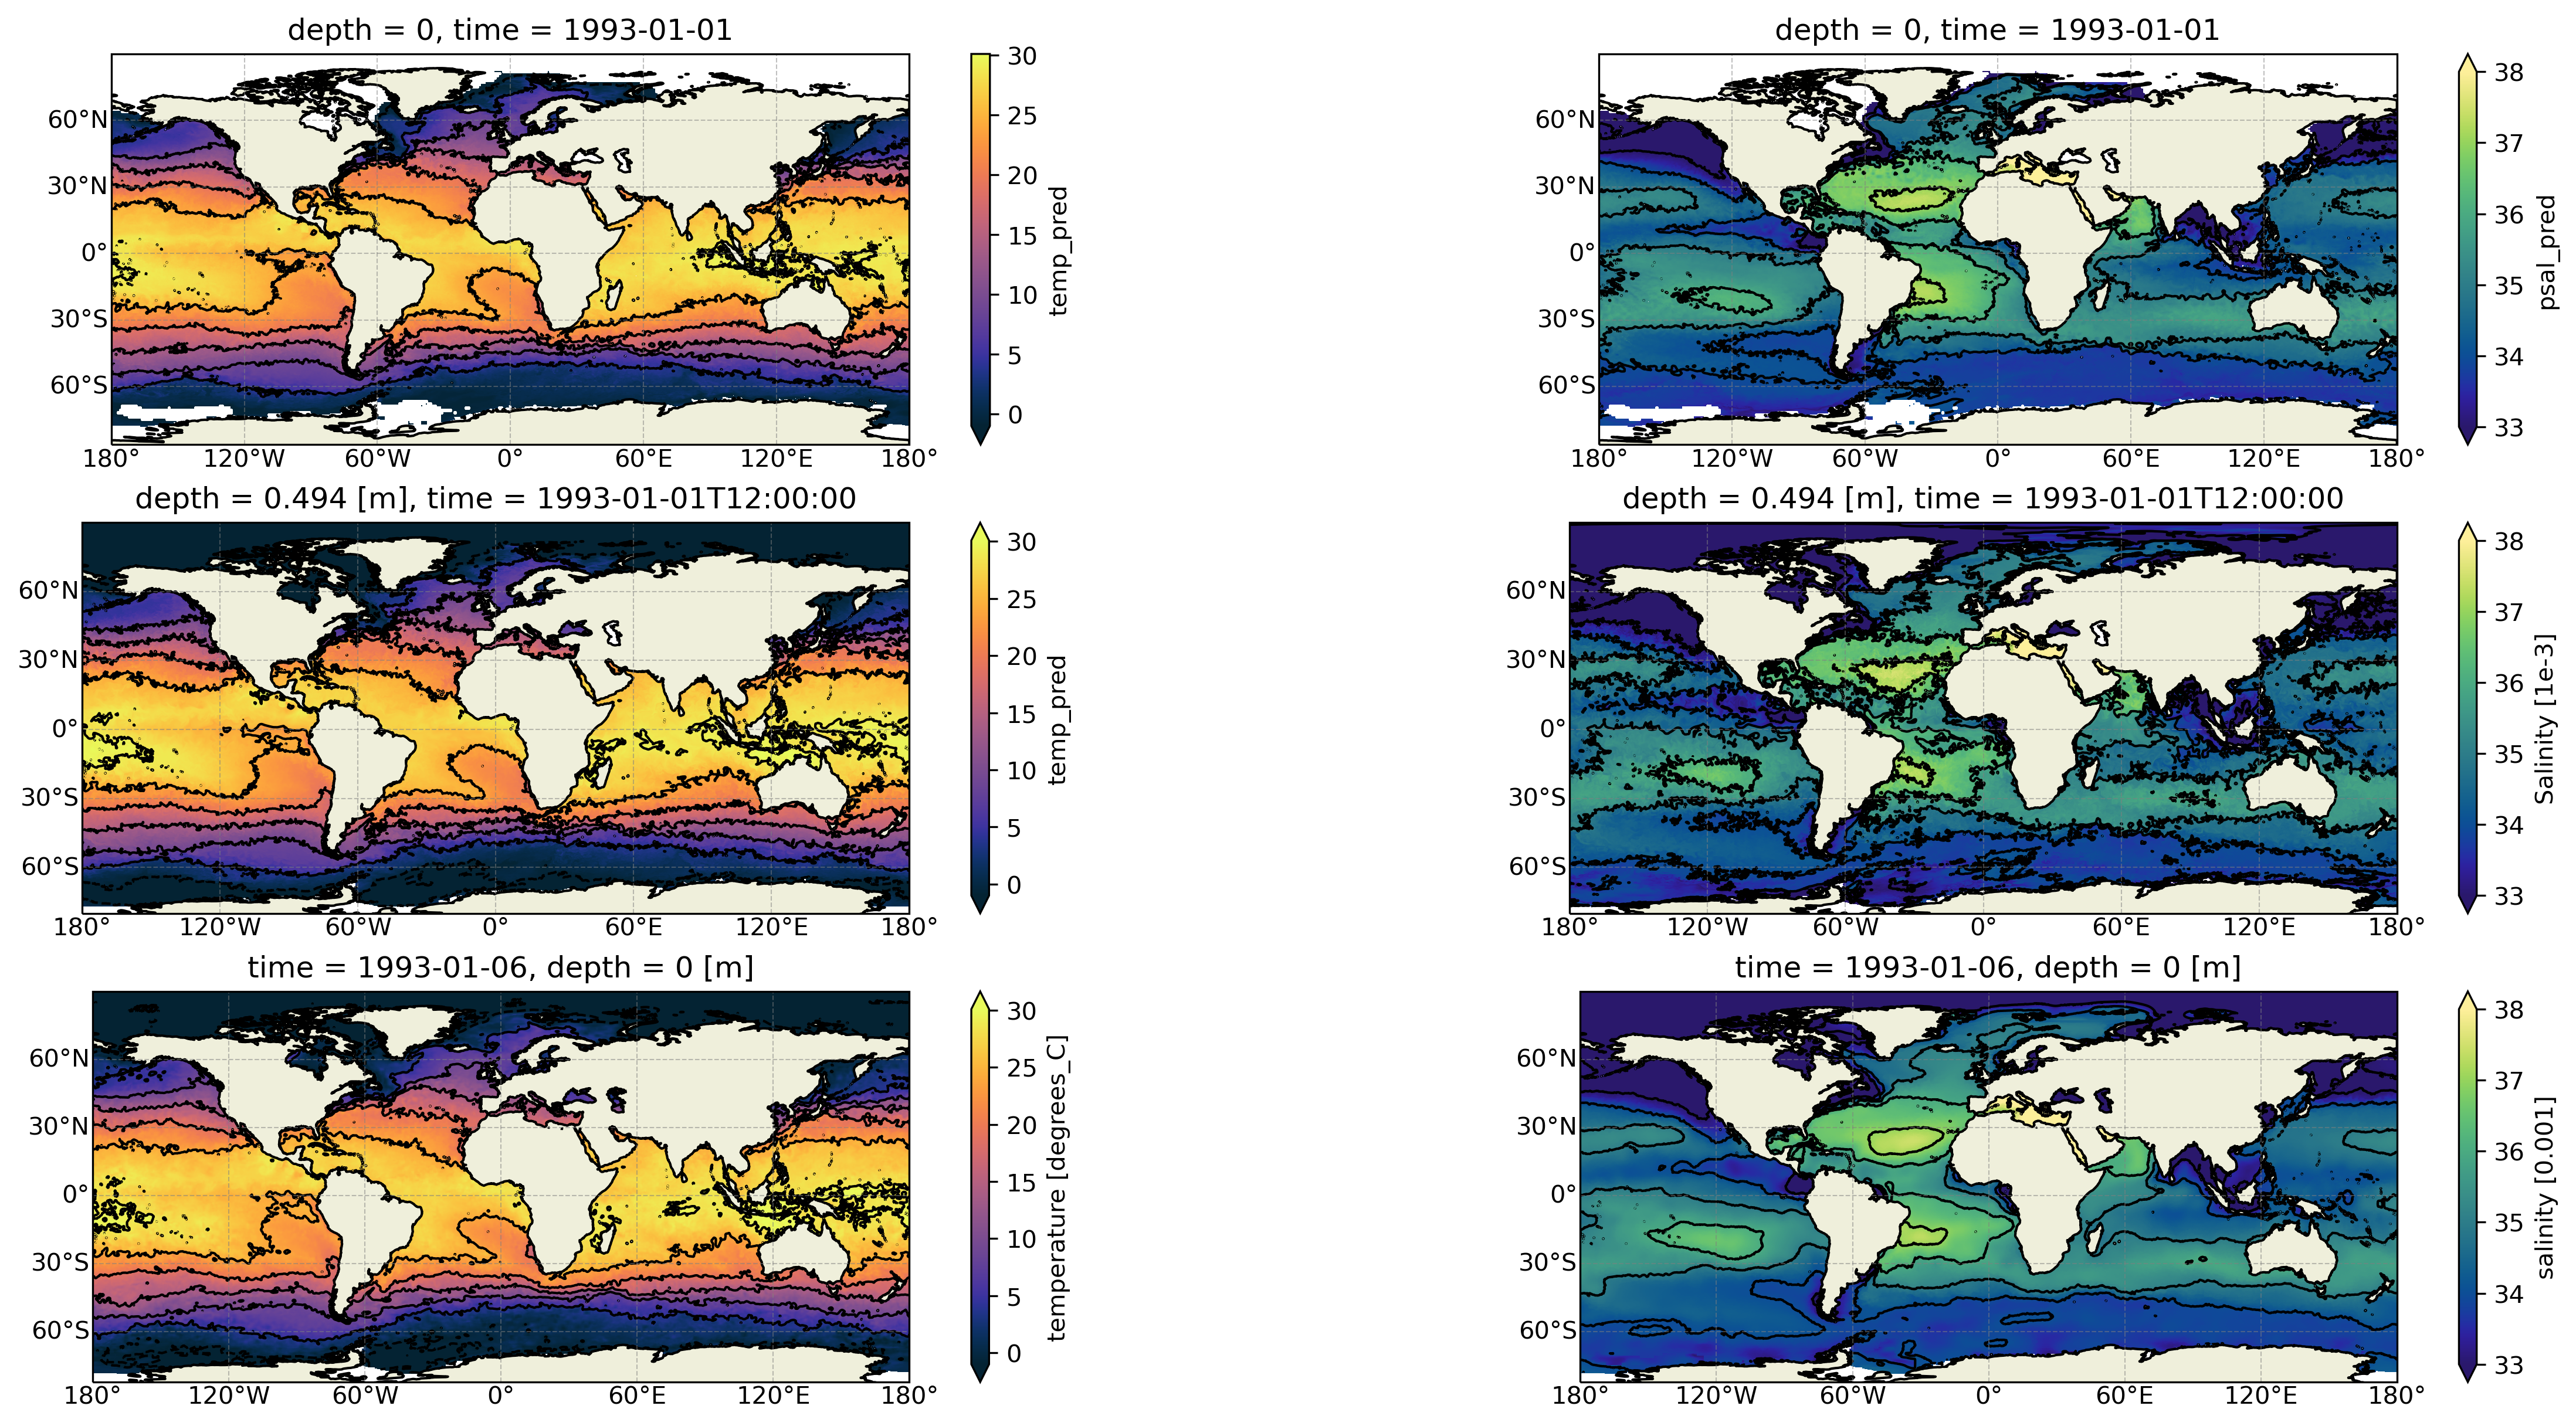

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=300, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
k = 0
de = [0,400]
Smin = 33
Tmin = -1
dsplt = osnet.sel(depth = de[k],method = 'nearest').squeeze()
Smax = 38 #dsplt.psal_pred.max().data
Tmax = dsplt.temp_pred.max().data
Tlev = np.arange(Tmin,Tmax,5)
Slev = np.arange(Smin,Smax,1)

#OSNET
dsplt.temp_pred.plot(cmap = cmocean.cm.thermal,center = False,ax = ax[0,0],vmin = Tmin,vmax = Tmax)
ax[0,0].contour(dsplt.longitude,dsplt.latitude,dsplt.temp_pred,colors = 'black'
             ,levels = Tlev,linewidths = 1)
dsplt.psal_pred.plot(cmap = cmocean.cm.haline,center = False,ax = ax[0,1],vmin = Smin,vmax = Smax)
ax[0,1].contour(dsplt.longitude,dsplt.latitude,dsplt.psal_pred,colors = 'black'
             ,levels = Slev,linewidths = 1)
#GLORYS
dsplt = glorys.sel(depth = de[k],method = 'nearest').squeeze()
dsplt.temp_pred.plot(cmap = cmocean.cm.thermal,center = False,ax = ax[1,0],vmin = Tmin,vmax = Tmax)
ax[1,0].contour(dsplt.longitude,dsplt.latitude,dsplt.temp_pred.squeeze(),colors = 'black'
             ,levels = Tlev,linewidths = 1)
dsplt.psal_pred.plot(cmap = cmocean.cm.haline,center = False,ax = ax[1,1],vmin = Smin,vmax = Smax)
ax[1,1].contour(dsplt.longitude,dsplt.latitude,dsplt.psal_pred,colors = 'black'
             ,levels = Slev,linewidths = 1)
#ARMOR3D
dsplt = armor.sel(depth = de[k],method = 'nearest').squeeze()
dsplt.to.plot(cmap = cmocean.cm.thermal,center = False,ax = ax[2,0],vmin = Tmin,vmax = Tmax)
ax[2,0].contour(dsplt.longitude,dsplt.latitude,dsplt.to,colors = 'black'
             ,levels = Tlev,linewidths = 1)
dsplt.so.plot(cmap = cmocean.cm.haline,center = False,ax = ax[2,1],vmin = Smin,vmax = Smax)
ax[2,1].contour(dsplt.longitude,dsplt.latitude,dsplt.so,colors = 'black'
             ,levels = Slev,linewidths = 1)

for i in np.arange(3):
    for j in np.arange(2):
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
#plt.savefig(pathfig + 'OSnet_Temp'+date+'.png', transparent=False)